# Content-Based Recommender System

Dit notebook implementeert een content-based recommender systeem voor de VKM dataset. Het systeem gebruikt de embeddings die gegenereerd zijn in de feature engineering notebook om vergelijkbare modules te vinden op basis van hun inhoud.

In [3]:
# Import benodigde libraries
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("Libraries succesvol geladen!")

Libraries succesvol geladen!


## Data Laden

We laden de dataset en de embeddings die gegenereerd zijn in de feature engineering fase.

In [4]:
# Laad de dataset
df = pd.read_csv('Uitgebreide_VKM_dataset_cleaned.csv')

print(f"Dataset shape: {df.shape}")
print(f"Aantal modules: {len(df)}")
print(f"\nEerste paar kolommen:")
print(df[['id', 'name', 'shortdescription', 'level']].head())

Dataset shape: (211, 20)
Aantal modules: 211

Eerste paar kolommen:
    id                          name  \
0  159  Kennismaking met Psychologie   
1  160   Learning and working abroad   
2  161       Proactieve zorgplanning   
3  162               Rouw en verlies   
4  163           Acuut complexe zorg   

                                    shortdescription  level  
0  Brein, gedragsbeinvloeding, ontwikkelingspsych...  NLQF5  
1  Internationaal, persoonlijke ontwikkeling, ver...  NLQF5  
2     Proactieve zorgplanning, cocreatie, ziekenhuis  NLQF5  
3  Rouw & verlies, palliatieve zorg & redeneren, ...  NLQF6  
4  Acute zorg, complexiteit, ziekenhuis, revalidatie  NLQF6  


In [5]:
# Laad alle embeddings
print("Laden van embeddings...")

# Laad individuele embeddings
shortdescription_embeddings = np.load('shortdescription_clean_embeddings.npy')
description_embeddings = np.load('description_clean_embeddings.npy')
content_embeddings = np.load('content_clean_embeddings.npy')
learningoutcomes_embeddings = np.load('learningoutcomes_clean_embeddings.npy')

# Laad gecombineerde embeddings
combined_embeddings = np.load('combined_embeddings.npy')

print(f"✓ Shortdescription embeddings: {shortdescription_embeddings.shape}")
print(f"✓ Description embeddings: {description_embeddings.shape}")
print(f"✓ Content embeddings: {content_embeddings.shape}")
print(f"✓ Learning outcomes embeddings: {learningoutcomes_embeddings.shape}")
print(f"✓ Combined embeddings: {combined_embeddings.shape}")
print(f"\nAlle embeddings succesvol geladen!")

Laden van embeddings...
✓ Shortdescription embeddings: (211, 384)
✓ Description embeddings: (211, 384)
✓ Content embeddings: (211, 384)
✓ Learning outcomes embeddings: (211, 384)
✓ Combined embeddings: (211, 1536)

Alle embeddings succesvol geladen!


## Content-Based Recommender Class

We creëren een recommender class die verschillende soorten aanbevelingen kan geven op basis van de embeddings.

In [6]:
class ContentBasedRecommender:
    """
    Content-Based Recommender System voor VKM modules.
    
    Deze class gebruikt embeddings om vergelijkbare modules te vinden
    op basis van hun inhoud (beschrijving, content, leerresultaten, etc.)
    """
    
    def __init__(self, df, embeddings_dict):
        """
        Initialiseer de recommender.
        
        Parameters:
        - df: DataFrame met module informatie
        - embeddings_dict: Dictionary met verschillende soorten embeddings
        """
        self.df = df.copy()
        self.embeddings_dict = embeddings_dict
        
        # Bereken similarity matrices voor verschillende embedding types
        self.similarity_matrices = {}
        for name, embeddings in embeddings_dict.items():
            self.similarity_matrices[name] = cosine_similarity(embeddings)
        
        print(f"✓ Recommender geïnitialiseerd met {len(df)} modules")
        print(f"✓ Beschikbare embedding types: {list(embeddings_dict.keys())}")
    
    def get_recommendations(self, module_id=None, module_name=None, n_recommendations=5, 
                           embedding_type='combined', min_similarity=0.0):
        """
        Krijg aanbevelingen voor een module.
        
        Parameters:
        - module_id: ID van de module (optioneel)
        - module_name: Naam van de module (optioneel)
        - n_recommendations: Aantal aanbevelingen
        - embedding_type: Type embedding om te gebruiken ('combined', 'content', etc.)
        - min_similarity: Minimale similarity score
        
        Returns:
        - DataFrame met aanbevolen modules
        """
        # Vind de module
        if module_id is not None:
            idx = self.df[self.df['id'] == module_id].index
            if len(idx) == 0:
                return f"Module met ID {module_id} niet gevonden"
            idx = idx[0]
        elif module_name is not None:
            idx = self.df[self.df['name'].str.contains(module_name, case=False, na=False)].index
            if len(idx) == 0:
                return f"Module met naam '{module_name}' niet gevonden"
            idx = idx[0]
        else:
            return "Geef een module_id of module_name op"
        
        # Haal similarity scores op
        similarity_matrix = self.similarity_matrices[embedding_type]
        similarity_scores = similarity_matrix[idx]
        
        # Filter op minimum similarity
        valid_indices = np.where(similarity_scores >= min_similarity)[0]
        valid_scores = similarity_scores[valid_indices]
        
        # Sorteer op similarity (exclusief de module zelf)
        sorted_indices = valid_indices[np.argsort(valid_scores)[::-1]]
        sorted_indices = sorted_indices[sorted_indices != idx]  # Verwijder de module zelf
        
        # Selecteer top N
        top_indices = sorted_indices[:n_recommendations]
        
        # Maak resultaat DataFrame
        recommendations = self.df.iloc[top_indices].copy()
        recommendations['similarity_score'] = similarity_scores[top_indices]
        
        # Selecteer relevante kolommen
        columns = ['id', 'name', 'shortdescription', 'level', 'studycredit', 
                  'location', 'similarity_score']
        available_columns = [col for col in columns if col in recommendations.columns]
        
        return recommendations[available_columns]
    
    def get_module_info(self, module_id=None, module_name=None):
        """
        Toon informatie over een module.
        """
        if module_id is not None:
            module = self.df[self.df['id'] == module_id]
        elif module_name is not None:
            module = self.df[self.df['name'].str.contains(module_name, case=False, na=False)]
        else:
            return "Geef een module_id of module_name op"
        
        if len(module) == 0:
            return "Module niet gevonden"
        
        return module.iloc[0]
    
    def compare_modules(self, module_id1, module_id2, show_details=True):
        """
        Vergelijk twee modules en toon hun similarity scores.
        """
        idx1 = self.df[self.df['id'] == module_id1].index
        idx2 = self.df[self.df['id'] == module_id2].index
        
        if len(idx1) == 0 or len(idx2) == 0:
            return "Een of beide modules niet gevonden"
        
        idx1, idx2 = idx1[0], idx2[0]
        
        print(f"Vergelijking tussen modules:")
        print(f"  Module 1: {self.df.iloc[idx1]['name']}")
        print(f"  Module 2: {self.df.iloc[idx2]['name']}")
        print(f"\nSimilarity scores per embedding type:")
        
        for name, sim_matrix in self.similarity_matrices.items():
            score = sim_matrix[idx1, idx2]
            print(f"  {name:20s}: {score:.4f}")
        
        if show_details:
            print(f"\n{'='*60}")
            print("Module 1 Details:")
            print(f"{'='*60}")
            print(f"Naam: {self.df.iloc[idx1]['name']}")
            print(f"Korte beschrijving: {self.df.iloc[idx1]['shortdescription'][:100]}...")
            
            print(f"\n{'='*60}")
            print("Module 2 Details:")
            print(f"{'='*60}")
            print(f"Naam: {self.df.iloc[idx2]['name']}")
            print(f"Korte beschrijving: {self.df.iloc[idx2]['shortdescription'][:100]}...")
    
    def find_similar_by_text(self, text, n_recommendations=5, embedding_type='combined'):
        """
        Vind modules vergelijkbaar met een gegeven tekst.
        (Vereist het sentence transformer model - voor toekomstige uitbreiding)
        """
        return "Deze functie vereist het sentence transformer model voor nieuwe tekst encoding."
    
    def get_statistics(self):
        """
        Toon statistieken over de similarity scores.
        """
        print(f"Recommender Statistieken:")
        print(f"{'='*60}")
        print(f"Aantal modules: {len(self.df)}")
        print(f"\nGemiddelde similarity scores per embedding type:")
        
        for name, sim_matrix in self.similarity_matrices.items():
            # Bereken gemiddelde similarity (exclusief diagonaal)
            mask = ~np.eye(sim_matrix.shape[0], dtype=bool)
            avg_similarity = sim_matrix[mask].mean()
            std_similarity = sim_matrix[mask].std()
            min_similarity = sim_matrix[mask].min()
            max_similarity = sim_matrix[mask].max()
            
            print(f"\n{name}:")
            print(f"  Gemiddelde: {avg_similarity:.4f}")
            print(f"  Std dev:    {std_similarity:.4f}")
            print(f"  Min:        {min_similarity:.4f}")
            print(f"  Max:        {max_similarity:.4f}")

print("✓ ContentBasedRecommender class gedefinieerd")

✓ ContentBasedRecommender class gedefinieerd


## Initialiseer Recommender

Nu initialiseren we de recommender met onze embeddings.

In [7]:
# Maak dictionary met alle embeddings
embeddings_dict = {
    'combined': combined_embeddings,
    'shortdescription': shortdescription_embeddings,
    'description': description_embeddings,
    'content': content_embeddings,
    'learningoutcomes': learningoutcomes_embeddings
}

# Initialiseer recommender
recommender = ContentBasedRecommender(df, embeddings_dict)

# Toon statistieken
recommender.get_statistics()

✓ Recommender geïnitialiseerd met 211 modules
✓ Beschikbare embedding types: ['combined', 'shortdescription', 'description', 'content', 'learningoutcomes']
Recommender Statistieken:
Aantal modules: 211

Gemiddelde similarity scores per embedding type:

combined:
  Gemiddelde: 0.2841
  Std dev:    0.1158
  Min:        -0.0690
  Max:        1.0000

shortdescription:
  Gemiddelde: 0.2250
  Std dev:    0.1465
  Min:        -0.1801
  Max:        1.0000

description:
  Gemiddelde: 0.3271
  Std dev:    0.1437
  Min:        -0.1867
  Max:        1.0000

content:
  Gemiddelde: 0.3172
  Std dev:    0.1480
  Min:        -0.1867
  Max:        1.0000

learningoutcomes:
  Gemiddelde: 0.3176
  Std dev:    0.2071
  Min:        -0.0499
  Max:        1.0000


## Voorbeeld 1: Aanbevelingen op basis van Module ID

Laten we aanbevelingen krijgen voor een specifieke module.

In [8]:
# Bekijk eerst de informatie van een module
module_id = 159  # Kennismaking met Psychologie
module_info = recommender.get_module_info(module_id=module_id)

print("=" * 80)
print("MODULE INFORMATIE")
print("=" * 80)
print(f"ID: {module_info['id']}")
print(f"Naam: {module_info['name']}")
print(f"Level: {module_info['level']}")
print(f"Studiepunten: {module_info['studycredit']}")
print(f"Locatie: {module_info['location']}")
print(f"\nKorte beschrijving:")
print(module_info['shortdescription'])
print(f"\nBeschrijving:")
print(module_info['description'][:300] + "...")

MODULE INFORMATIE
ID: 159
Naam: Kennismaking met Psychologie
Level: NLQF5
Studiepunten: 15
Locatie: Den Bosch

Korte beschrijving:
Brein, gedragsbeinvloeding, ontwikkelingspsychologie, gespreksvoering en ontwikkelingsfasen.

Beschrijving:
In deze module leer je hoe je gedrag van jezelf en van anderen kunt begrijpen en beinvloeden. Je maakt kennis met de basistheorie van Psychologie. Aan bod komen onderwerpen die te maken hebben met cognitieve, biologische en ontwikkelingspsychologie....


In [9]:
# Krijg aanbevelingen voor deze module
print("\n" + "=" * 80)
print("TOP 5 AANBEVOLEN MODULES (op basis van combined embeddings)")
print("=" * 80)

recommendations = recommender.get_recommendations(
    module_id=module_id,
    n_recommendations=5,
    embedding_type='combined'
)

# Toon resultaten
for idx, row in recommendations.iterrows():
    print(f"\n{row['name']}")
    print(f"  Similarity: {row['similarity_score']:.4f}")
    print(f"  Level: {row['level']} | Credits: {row['studycredit']} | Locatie: {row['location']}")
    print(f"  {row['shortdescription'][:100]}...")


TOP 5 AANBEVOLEN MODULES (op basis van combined embeddings)

Didactiek voor N&G en N&T
  Similarity: 0.4576
  Level: NLQF6 | Credits: 15 | Locatie: Breda
  didactiek, docentschap, natuur, techniek, gezondheid...

Stevig staan in de Jeugdzorg
  Similarity: 0.4562
  Level: NLQF6 | Credits: 30 | Locatie: Den Bosch
  Jeugdhulp en Jeugdbescherming, gezinnen onder druk, kinderen en met uitdagingen in de ontwikkeling, ...

Werken vanuit je doelgroep
  Similarity: 0.4506
  Level: NLQF5 | Credits: 15 | Locatie: Breda
  Doelgroep, zorg, welzijn, interdisciplinair, samenwerken, inclusie...

Organizational Behavior (samenwerking HRM - IVK)
  Similarity: 0.4459
  Level: NLQF5 | Credits: 30 | Locatie: Breda
  organisatiegedrag, groepsdynamica, verandermanagement, organisatiecultuur, leiderschap...

Inclusief samenwerken zonder verliezers
  Similarity: 0.4437
  Level: NLQF6 | Credits: 15 | Locatie: Breda
  Corporate antropologie, Omgevingscommunicatie, Deep Democracy, Organisatiecultuur,  Veranderin

## Voorbeeld 2: Aanbevelingen op basis van Module Naam

We kunnen ook zoeken op module naam (gedeeltelijke match).

In [10]:
# Zoek module op naam
search_term = "zorg"
print(f"Zoeken naar modules met '{search_term}' in de naam...")

matching_modules = df[df['name'].str.contains(search_term, case=False, na=False)]
print(f"\nGevonden {len(matching_modules)} modules:")
for idx, row in matching_modules.head(3).iterrows():
    print(f"  - {row['name']} (ID: {row['id']})")

# Selecteer eerste match voor aanbevelingen
if len(matching_modules) > 0:
    selected_module = matching_modules.iloc[0]
    print(f"\n{'='*80}")
    print(f"AANBEVELINGEN VOOR: {selected_module['name']}")
    print(f"{'='*80}")
    
    recommendations = recommender.get_recommendations(
        module_id=selected_module['id'],
        n_recommendations=5,
        embedding_type='combined',
        min_similarity=0.3
    )
    
    display(recommendations)

Zoeken naar modules met 'zorg' in de naam...

Gevonden 15 modules:
  - Proactieve zorgplanning (ID: 161)
  - Acuut complexe zorg (ID: 163)
  - Profiel specifieke modulen Welzijn & Samenleving, Jeugd, Zorg (ID: 165)

AANBEVELINGEN VOOR: Proactieve zorgplanning


,id,name,shortdescription,level,studycredit,location,similarity_score
4,163,Acuut complexe zorg,"Acute zorg, complexiteit, ziekenhuis, revalidatie",NLQF6,30,Den Bosch,0.680619
5,164,Kraam kind en jeugd,"Jeugdzorg, neonatologie, verloskunde, kindzorg",NLQF6,30,Den Bosch,0.558756
1,160,Learning and working abroad,"Internationaal, persoonlijke ontwikkeling, ver...",NLQF5,15,Den Bosch,0.554538
77,259,Module 3.4 Duurzaam gebouwde omgeving - Gezond...,"Interdisciplinair, wellbeing, bouwen voor de zorg",NLQF6,15,Den Bosch en Tilburg,0.506537
191,378,Innovatie door Service Design,samen leren met proffesionals uit de wereld va...,NLQF6,30,Breda en Den Bosch,0.468256


## Voorbeeld 3: Vergelijk Embedding Types

Laten we zien hoe verschillende embedding types verschillende aanbevelingen geven.

In [11]:
# Vergelijk aanbevelingen voor verschillende embedding types
test_module_id = 162  # Rouw en verlies

print(f"Module: {df[df['id'] == test_module_id]['name'].values[0]}")
print("="*80)

embedding_types = ['combined', 'shortdescription', 'description', 'content', 'learningoutcomes']

for emb_type in embedding_types:
    print(f"\n{'='*80}")
    print(f"Aanbevelingen op basis van: {emb_type.upper()}")
    print(f"{'='*80}")
    
    recs = recommender.get_recommendations(
        module_id=test_module_id,
        n_recommendations=3,
        embedding_type=emb_type
    )
    
    for idx, row in recs.iterrows():
        print(f"  {row['similarity_score']:.4f} - {row['name']}")

Module: Rouw en verlies

Aanbevelingen op basis van: COMBINED
  0.5111 - Patronen doorbreken: basis
  0.4525 - Werken vanuit je doelgroep
  0.4340 - Module 3.4 Duurzaam gebouwde omgeving - Gezondheid en zorg

Aanbevelingen op basis van: SHORTDESCRIPTION
  0.5956 - Patronen doorbreken: basis
  0.5579 - Patronen doorbreken / sociale verbinding & welzijn
  0.4950 - GGZ Agoog  

Aanbevelingen op basis van: DESCRIPTION
  0.6799 - Palliatieve zorg
  0.6694 - Oncologie
  0.5638 - Werken vanuit je doelgroep

Aanbevelingen op basis van: CONTENT
  0.6799 - Palliatieve zorg
  0.5638 - Werken vanuit je doelgroep
  0.4897 - Smart Health

Aanbevelingen op basis van: LEARNINGOUTCOMES
  0.5929 - Proactieve zorgplanning
  0.5661 - Proefdierkunde
  0.5575 - Kraam kind en jeugd


## Voorbeeld 4: Module Vergelijking

Vergelijk twee specifieke modules met elkaar.

In [12]:
# Vergelijk twee modules
module1_id = 159  # Kennismaking met Psychologie
module2_id = 162  # Rouw en verlies

recommender.compare_modules(module1_id, module2_id, show_details=True)

Vergelijking tussen modules:
  Module 1: Kennismaking met Psychologie
  Module 2: Rouw en verlies

Similarity scores per embedding type:
  combined            : 0.3059
  shortdescription    : 0.1802
  description         : 0.3366
  content             : 0.3366
  learningoutcomes    : 0.4963

Module 1 Details:
Naam: Kennismaking met Psychologie
Korte beschrijving: Brein, gedragsbeinvloeding, ontwikkelingspsychologie, gespreksvoering en ontwikkelingsfasen....

Module 2 Details:
Naam: Rouw en verlies
Korte beschrijving: Rouw & verlies, palliatieve zorg & redeneren, trauma, culturele diversiteit...


## Visualisatie: Similarity Heatmap

Visualiseer de similarity tussen een selectie van modules.

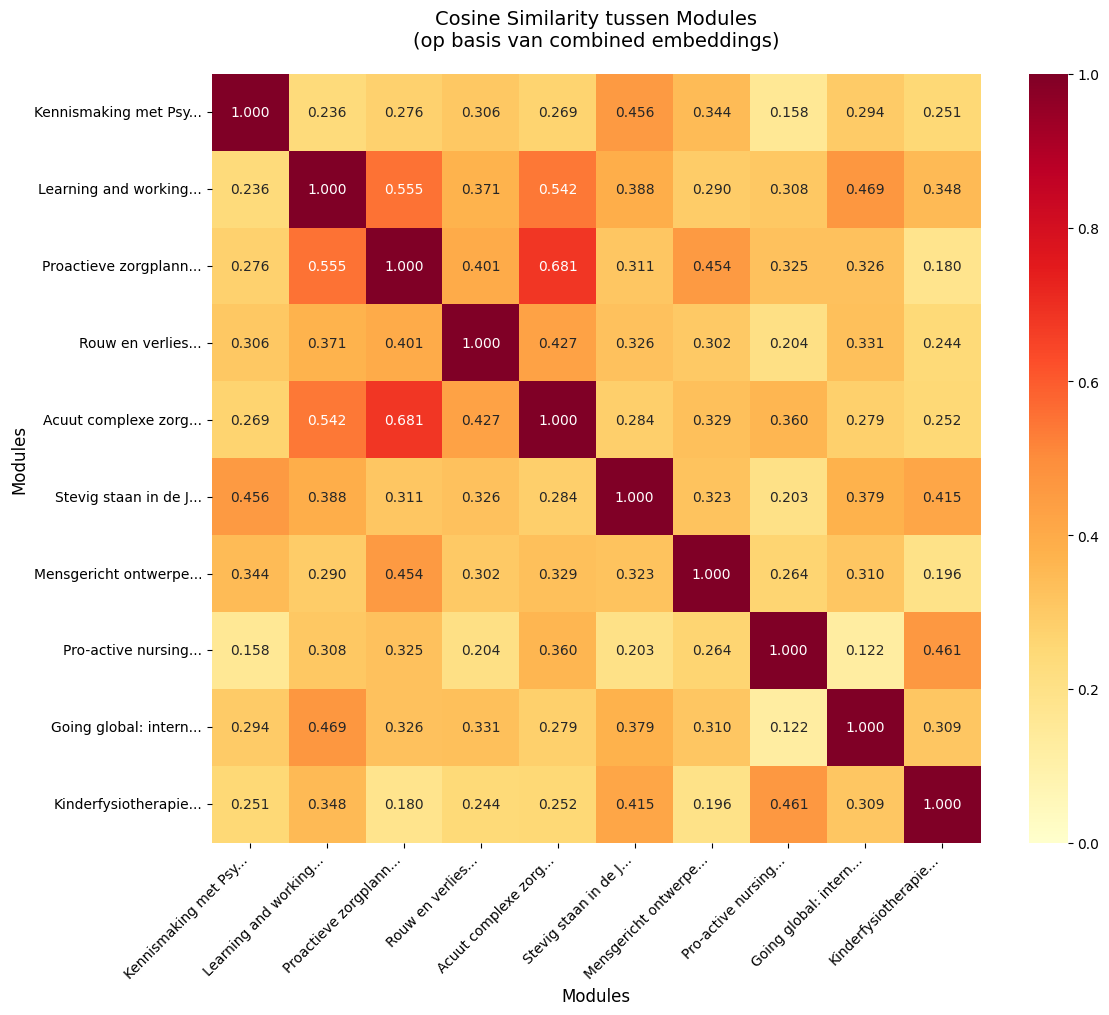


Interpretatie:
- Hoe roder de kleur, hoe hoger de similarity tussen modules
- Diagonaal is altijd 1.0 (module met zichzelf)
- Gebruik deze matrix om snel te zien welke modules het meest vergelijkbaar zijn


In [13]:
# Selecteer een subset van modules voor visualisatie
sample_indices = [0, 1, 2, 3, 4, 10, 15, 20, 25, 30]
sample_df = df.iloc[sample_indices]

# Haal similarity matrix op voor deze modules
sim_matrix = recommender.similarity_matrices['combined']
sample_sim_matrix = sim_matrix[np.ix_(sample_indices, sample_indices)]

# Maak heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(sample_sim_matrix, 
            annot=True, 
            fmt='.3f',
            cmap='YlOrRd',
            xticklabels=[f"{row['name'][:20]}..." for _, row in sample_df.iterrows()],
            yticklabels=[f"{row['name'][:20]}..." for _, row in sample_df.iterrows()],
            vmin=0, vmax=1,
            square=True)

plt.title('Cosine Similarity tussen Modules\n(op basis van combined embeddings)', fontsize=14, pad=20)
plt.xlabel('Modules', fontsize=12)
plt.ylabel('Modules', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\nInterpretatie:")
print("- Hoe roder de kleur, hoe hoger de similarity tussen modules")
print("- Diagonaal is altijd 1.0 (module met zichzelf)")
print("- Gebruik deze matrix om snel te zien welke modules het meest vergelijkbaar zijn")

## Visualisatie: Similarity Distributie

Bekijk de distributie van similarity scores in de dataset.

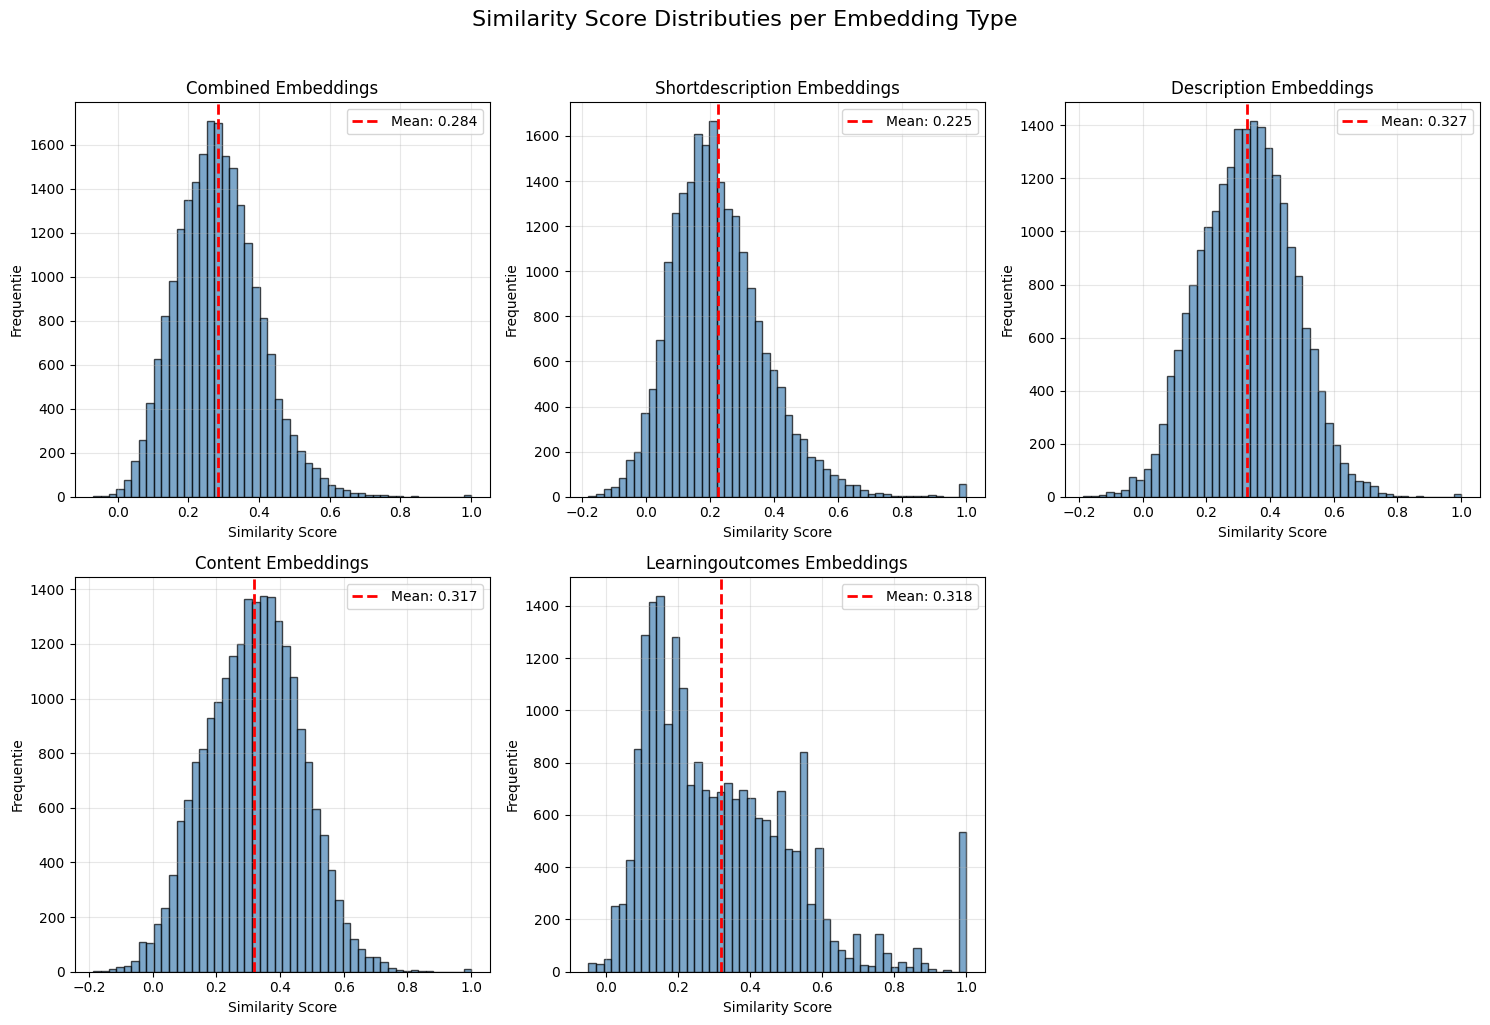


Observaties:
- De gemiddelde similarity verschilt per embedding type
- Combined embeddings combineren informatie uit alle tekstuele features
- Hogere similarity scores duiden op meer vergelijkbare modules


In [14]:
# Vergelijk similarity distributies voor verschillende embedding types
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

embedding_types = ['combined', 'shortdescription', 'description', 'content', 'learningoutcomes']

for idx, emb_type in enumerate(embedding_types):
    sim_matrix = recommender.similarity_matrices[emb_type]
    
    # Extract upper triangle (zonder diagonaal)
    mask = np.triu(np.ones_like(sim_matrix, dtype=bool), k=1)
    similarity_scores = sim_matrix[mask]
    
    # Plot histogram
    axes[idx].hist(similarity_scores, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
    axes[idx].axvline(similarity_scores.mean(), color='red', linestyle='--', linewidth=2, 
                      label=f'Mean: {similarity_scores.mean():.3f}')
    axes[idx].set_xlabel('Similarity Score')
    axes[idx].set_ylabel('Frequentie')
    axes[idx].set_title(f'{emb_type.capitalize()} Embeddings')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

# Verwijder laatste lege subplot
axes[-1].remove()

plt.suptitle('Similarity Score Distributies per Embedding Type', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

print("\nObservaties:")
print("- De gemiddelde similarity verschilt per embedding type")
print("- Combined embeddings combineren informatie uit alle tekstuele features")
print("- Hogere similarity scores duiden op meer vergelijkbare modules")

## Interactieve Recommender Functie

Maak een handige functie om snel aanbevelingen te krijgen.

In [15]:
def recommend_modules(module_identifier, n=5, embedding_type='combined', show_details=True):
    """
    Handige wrapper functie om aanbevelingen te krijgen.
    
    Parameters:
    - module_identifier: Module ID (int) of naam (str)
    - n: Aantal aanbevelingen
    - embedding_type: Type embedding om te gebruiken
    - show_details: Toon gedetailleerde informatie
    """
    # Bepaal of het een ID of naam is
    if isinstance(module_identifier, int):
        module_info = recommender.get_module_info(module_id=module_identifier)
        recommendations = recommender.get_recommendations(
            module_id=module_identifier,
            n_recommendations=n,
            embedding_type=embedding_type
        )
    else:
        module_info = recommender.get_module_info(module_name=module_identifier)
        if isinstance(module_info, str):  # Error message
            return module_info
        recommendations = recommender.get_recommendations(
            module_name=module_identifier,
            n_recommendations=n,
            embedding_type=embedding_type
        )
    
    if show_details:
        print("=" * 80)
        print("ORIGINELE MODULE")
        print("=" * 80)
        print(f"Naam: {module_info['name']}")
        print(f"Level: {module_info['level']} | Credits: {module_info['studycredit']}")
        print(f"Beschrijving: {module_info['shortdescription'][:150]}...")
        
        print(f"\n{'=' * 80}")
        print(f"TOP {n} AANBEVOLEN MODULES (embedding type: {embedding_type})")
        print("=" * 80)
        
        for i, (idx, row) in enumerate(recommendations.iterrows(), 1):
            print(f"\n{i}. {row['name']}")
            print(f"   Similarity: {row['similarity_score']:.4f}")
            print(f"   Level: {row['level']} | Credits: {row['studycredit']} | Locatie: {row['location']}")
            if 'shortdescription' in row:
                print(f"   {row['shortdescription'][:120]}...")
    
    return recommendations

# Test de functie
print("Functie 'recommend_modules' succesvol gedefinieerd!")
print("\nGebruik:")
print("  recommend_modules(159, n=5)  # Aanbevelingen voor module ID 159")
print("  recommend_modules('psychologie', n=3)  # Zoek op naam")

Functie 'recommend_modules' succesvol gedefinieerd!

Gebruik:
  recommend_modules(159, n=5)  # Aanbevelingen voor module ID 159
  recommend_modules('psychologie', n=3)  # Zoek op naam


In [16]:
# Test de interactieve functie
recommend_modules(160, n=5, embedding_type='combined')

ORIGINELE MODULE
Naam: Learning and working abroad
Level: NLQF5 | Credits: 15
Beschrijving: Internationaal, persoonlijke ontwikkeling, verpleegkunde...

TOP 5 AANBEVOLEN MODULES (embedding type: combined)

1. Proactieve zorgplanning
   Similarity: 0.5545
   Level: NLQF5 | Credits: 15 | Locatie: Den Bosch
   Proactieve zorgplanning, cocreatie, ziekenhuis...

2. Acuut complexe zorg
   Similarity: 0.5422
   Level: NLQF6 | Credits: 30 | Locatie: Den Bosch
   Acute zorg, complexiteit, ziekenhuis, revalidatie...

3. Kraam kind en jeugd
   Similarity: 0.5396
   Level: NLQF6 | Credits: 30 | Locatie: Den Bosch
   Jeugdzorg, neonatologie, verloskunde, kindzorg...

4. Module 3.4 Duurzaam gebouwde omgeving - Gezondheid en zorg
   Similarity: 0.5092
   Level: NLQF6 | Credits: 15 | Locatie: Den Bosch en Tilburg
   Interdisciplinair, wellbeing, bouwen voor de zorg...

5. Studeren buitenland
   Similarity: 0.4745
   Level: NLQF6 | Credits: 30 | Locatie: Breda
   Internationalisering, ervaring buitenla

,id,name,shortdescription,level,studycredit,location,similarity_score
2,161,Proactieve zorgplanning,"Proactieve zorgplanning, cocreatie, ziekenhuis",NLQF5,15,Den Bosch,0.554538
4,163,Acuut complexe zorg,"Acute zorg, complexiteit, ziekenhuis, revalidatie",NLQF6,30,Den Bosch,0.542169
5,164,Kraam kind en jeugd,"Jeugdzorg, neonatologie, verloskunde, kindzorg",NLQF6,30,Den Bosch,0.539557
77,259,Module 3.4 Duurzaam gebouwde omgeving - Gezond...,"Interdisciplinair, wellbeing, bouwen voor de zorg",NLQF6,15,Den Bosch en Tilburg,0.509243
50,209,Studeren buitenland,"Internationalisering, ervaring buitenland, SDG's",NLQF6,30,Breda,0.474543


## Evaluatie: Top-K Aanbevelingen

Analyseer de kwaliteit van de aanbevelingen door te kijken naar de gemiddelde similarity scores.

EVALUATIE VAN TOP-5 AANBEVELINGEN
(Gebaseerd op 30 willekeurige modules)

Gemiddelde similarity over alle modules:
  Mean: 0.5819
  Std:  0.0684
  Min:  0.4526
  Max:  0.7521


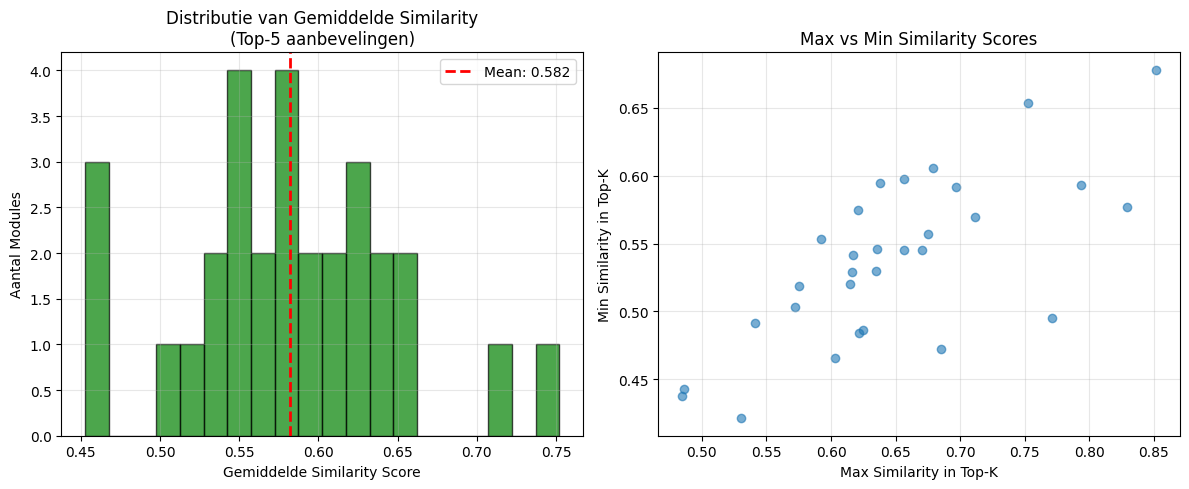

In [17]:
# Evalueer de kwaliteit van aanbevelingen
def evaluate_recommendations(n_recommendations=5, sample_size=20):
    """
    Evalueer de gemiddelde similarity van top-K aanbevelingen.
    """
    results = []
    
    # Sample random modules
    sample_modules = df.sample(n=min(sample_size, len(df)))
    
    for _, module in sample_modules.iterrows():
        recs = recommender.get_recommendations(
            module_id=module['id'],
            n_recommendations=n_recommendations,
            embedding_type='combined'
        )
        
        avg_similarity = recs['similarity_score'].mean()
        max_similarity = recs['similarity_score'].max()
        min_similarity = recs['similarity_score'].min()
        
        results.append({
            'module_id': module['id'],
            'module_name': module['name'],
            'avg_similarity': avg_similarity,
            'max_similarity': max_similarity,
            'min_similarity': min_similarity
        })
    
    results_df = pd.DataFrame(results)
    
    print("="*80)
    print(f"EVALUATIE VAN TOP-{n_recommendations} AANBEVELINGEN")
    print(f"(Gebaseerd op {sample_size} willekeurige modules)")
    print("="*80)
    print(f"\nGemiddelde similarity over alle modules:")
    print(f"  Mean: {results_df['avg_similarity'].mean():.4f}")
    print(f"  Std:  {results_df['avg_similarity'].std():.4f}")
    print(f"  Min:  {results_df['avg_similarity'].min():.4f}")
    print(f"  Max:  {results_df['avg_similarity'].max():.4f}")
    
    # Visualisatie
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(results_df['avg_similarity'], bins=20, edgecolor='black', alpha=0.7, color='green')
    plt.xlabel('Gemiddelde Similarity Score')
    plt.ylabel('Aantal Modules')
    plt.title(f'Distributie van Gemiddelde Similarity\n(Top-{n_recommendations} aanbevelingen)')
    plt.axvline(results_df['avg_similarity'].mean(), color='red', linestyle='--', 
                linewidth=2, label=f"Mean: {results_df['avg_similarity'].mean():.3f}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.scatter(results_df['max_similarity'], results_df['min_similarity'], alpha=0.6)
    plt.xlabel('Max Similarity in Top-K')
    plt.ylabel('Min Similarity in Top-K')
    plt.title('Max vs Min Similarity Scores')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return results_df

# Run evaluatie
eval_results = evaluate_recommendations(n_recommendations=5, sample_size=30)

## Samenvatting en Next Steps

### Wat hebben we gebouwd?

We hebben een **Content-Based Recommender System** gecreëerd dat:
- ✅ Embeddings gebruikt van verschillende tekstuele features (beschrijving, content, leerresultaten)
- ✅ Cosine similarity berekent tussen modules
- ✅ Aanbevelingen kan geven op basis van module ID of naam
- ✅ Verschillende embedding types kan vergelijken
- ✅ Modules met elkaar kan vergelijken
- ✅ Visualisaties biedt voor similarity analyse

### Hoe te gebruiken?

```python
# Eenvoudige aanbevelingen
recommend_modules(159, n=5)

# Zoeken op naam
recommend_modules('psychologie', n=3)

# Specifiek embedding type gebruiken
recommend_modules(162, n=5, embedding_type='content')

# Modules vergelijken
recommender.compare_modules(159, 162)
```


## Interactieve Zoekfunctie

Gebruik deze interactieve functie om te zoeken naar modules die bij je passen!

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML

def create_interactive_search():
    """
    Interactieve zoekfunctie met ipywidgets voor modules.
    Je kunt zoeken op:
    1. Module ID (bijvoorbeeld: 159)
    2. Module naam (bijvoorbeeld: psychologie)
    3. Beschrijving/keywords (bijvoorbeeld: zorg internationaal)
    """
    # Create widgets
    search_input = widgets.Text(
        value='',
        placeholder='Type hier je zoekterm (ID, naam of keywords)...',
        description='Zoeken:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='70%')
    )
    
    search_button = widgets.Button(
        description='Zoek Module',
        button_style='primary',
        tooltip='Klik om te zoeken',
        icon='search'
    )
    
    clear_button = widgets.Button(
        description='Wis',
        button_style='warning',
        tooltip='Wis resultaten'
    )
    
    n_recs_slider = widgets.IntSlider(
        value=5,
        min=1,
        max=10,
        step=1,
        description='Aantal aanbevelingen:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='50%')
    )
    
    show_recs_checkbox = widgets.Checkbox(
        value=True,
        description='Toon vergelijkbare modules',
        style={'description_width': 'initial'}
    )
    
    output = widgets.Output()
    
    # Search function
    def search_modules(b):
        with output:
            clear_output()
            user_input = search_input.value.strip()
            
            if not user_input:
                print("Voer een zoekterm in!")
                return
            
            display(HTML(f"<h3>Zoeken naar: '{user_input}'</h3>"))
            display(HTML("<hr>"))
            
            # Bepaal zoektype
            if user_input.isdigit():
                # Zoek op ID
                module_id = int(user_input)
                module_info = recommender.get_module_info(module_id=module_id)
                
                if isinstance(module_info, str):
                    print(f"❌ {module_info}")
                    return
                
                # Display module info
                display(HTML("<h4>Module gevonden!</h4>"))
                display(HTML(f"""
                <div style='background-color: #f0f8ff; padding: 15px; border-radius: 5px; border-left: 4px solid #4CAF50;'>
                    <h3>📚 {module_info['name']}</h3>
                    <p><strong>ID:</strong> {module_info['id']}</p>
                    <p><strong>Level:</strong> {module_info['level']} | 
                       <strong>Credits:</strong> {module_info['studycredit']} | 
                       <strong>Locatie:</strong> {module_info['location']}</p>
                    <p><strong>Beschrijving:</strong> {module_info['shortdescription']}</p>
                </div>
                """))
                
                # Show recommendations if checkbox is checked
                if show_recs_checkbox.value:
                    recs = recommender.get_recommendations(
                        module_id=module_id, 
                        n_recommendations=n_recs_slider.value, 
                        embedding_type='combined'
                    )
                    display(HTML(f"<h4>Top {n_recs_slider.value} Vergelijkbare Modules:</h4>"))
                    
                    for i, (idx, row) in enumerate(recs.iterrows(), 1):
                        similarity_color = '#4CAF50' if row['similarity_score'] > 0.5 else '#FF9800' if row['similarity_score'] > 0.3 else '#f44336'
                        display(HTML(f"""
                        <div style='background-color: #fafafa; padding: 10px; margin: 5px 0; border-radius: 5px; border-left: 3px solid {similarity_color};'>
                            <h4>{i}. {row['name']}</h4>
                            <p><strong>Similarity:</strong> <span style='color: {similarity_color}; font-weight: bold;'>{row['similarity_score']:.4f}</span> | 
                               <strong>Level:</strong> {row['level']} | 
                               <strong>Credits:</strong> {row['studycredit']} | 
                               <strong>Locatie:</strong> {row['location']}</p>
                            <p style='color: #666;'>{row['shortdescription'][:120]}...</p>
                        </div>
                        """))
            
            else:
                # Zoek op naam of keywords
                matching_modules = df[df['name'].str.contains(user_input, case=False, na=False, regex=False)]
                
                if len(matching_modules) == 0:
                    # Zoek in alle tekstuele kolommen
                    mask = (df['name'].str.contains(user_input, case=False, na=False, regex=False) | 
                           df['shortdescription'].str.contains(user_input, case=False, na=False, regex=False) |
                           df['description'].str.contains(user_input, case=False, na=False, regex=False))
                    matching_modules = df[mask]
                
                if len(matching_modules) == 0:
                    print(f"Geen modules gevonden met '{user_input}'")
                    print("Probeer andere zoektermen of een module ID")
                    return
                
                display(HTML(f"<h4>{len(matching_modules)} module(s) gevonden!</h4>"))
                
                # Toon top 5 matches
                display_count = min(5, len(matching_modules))
                display(HTML(f"<h4>Top {display_count} Resultaten:</h4>"))
                
                for i, (idx, row) in enumerate(matching_modules.head(5).iterrows(), 1):
                    display(HTML(f"""
                    <div style='background-color: #f0f8ff; padding: 10px; margin: 5px 0; border-radius: 5px; border-left: 4px solid #2196F3;'>
                        <h4>{i}. {row['name']} <span style='color: #666; font-size: 0.9em;'>(ID: {row['id']})</span></h4>
                        <p><strong>Level:</strong> {row['level']} | 
                           <strong>Credits:</strong> {row['studycredit']} | 
                           <strong>Locatie:</strong> {row['location']}</p>
                        <p style='color: #666;'>{row['shortdescription'][:120]}...</p>
                    </div>
                    """))
                
                # Show recommendations for first match if checkbox is checked
                if show_recs_checkbox.value and len(matching_modules) > 0:
                    selected_id = matching_modules.iloc[0]['id']
                    selected_name = matching_modules.iloc[0]['name']
                    
                    recs = recommender.get_recommendations(
                        module_id=selected_id, 
                        n_recommendations=n_recs_slider.value, 
                        embedding_type='combined'
                    )
                    
                    display(HTML(f"<h4>🎯 Top {n_recs_slider.value} Modules vergelijkbaar met '{selected_name}':</h4>"))
                    
                    for i, (idx, row) in enumerate(recs.iterrows(), 1):
                        similarity_color = '#4CAF50' if row['similarity_score'] > 0.5 else '#FF9800' if row['similarity_score'] > 0.3 else '#f44336'
                        display(HTML(f"""
                        <div style='background-color: #fafafa; padding: 10px; margin: 5px 0; border-radius: 5px; border-left: 3px solid {similarity_color};'>
                            <h4>{i}. {row['name']}</h4>
                            <p><strong>Similarity:</strong> <span style='color: {similarity_color}; font-weight: bold;'>{row['similarity_score']:.4f}</span> | 
                               <strong>Level:</strong> {row['level']} | 
                               <strong>Credits:</strong> {row['studycredit']} | 
                               <strong>Locatie:</strong> {row['location']}</p>
                            <p style='color: #666;'>{row['shortdescription'][:120]}...</p>
                        </div>
                        """))
    
    def clear_results(b):
        with output:
            clear_output()
            search_input.value = ''
    
    # Attach event handlers
    search_button.on_click(search_modules)
    clear_button.on_click(clear_results)
    
    # Layout
    display(HTML("""
    <div style='background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); 
                padding: 20px; 
                border-radius: 10px; 
                color: white; 
                margin-bottom: 20px;'>
        <h2 style='margin: 0;'>🔍 Interactieve Module Zoeker</h2>
        <p style='margin: 5px 0 0 0;'>Zoek op module ID, naam, of trefwoorden</p>
    </div>
    """))
    
    display(widgets.VBox([
        search_input,
        widgets.HBox([search_button, clear_button]),
        show_recs_checkbox,
        n_recs_slider,
        output
    ]))

print("Interactieve zoekfunctie met widgets geladen!")
print("Gebruik: create_interactive_search()")

✅ Interactieve zoekfunctie met widgets geladen!
💡 Gebruik: create_interactive_search()


In [19]:
# Start de interactieve zoekfunctie met widgets
# Voer deze cel uit en gebruik de zoekbalk!
create_interactive_search()